# Thin Plate Splines Transformations

**Purpose:** The purpose of this experiment to implement thin plate spline transformations on images. The goal is to help normalize images of charts that have been folded or bent. TPS registration will be performed post-homography


## What are Thin Plate Splines

For our purpose, a thin plate spline transformation can be defined as follows:  
Given a set of "source" points $P_s$ and a corresponding set of "destination" points $P_d$, the thin plate spline transformation is a function  
$f_{tps}(p) | \forall p_s \in P_s, f_{tps}$ and $f$ is the function when "bends" all other points the least among all differentiable functions (meaning it minimizes an energy function).

![thin_plate_spline_example](https://github.com/user-attachments/assets/9f269c79-6d5d-4090-988c-39ee9e928ff0)

In this image there are two sets of points which form fish shapes. The red '+' points represent the destination points, and the green 'o' points represent the source points. On the right we see the thin plate spline deformation which makes all the green points exactly match all the red points, and we can also see a grid that shows where all other points on the plane will be mapped as well.

## Benefits for Image Registration

While the homography is a very reliable transformation, it is limited to purely linear transformations (ex: rotation, scaling, shear).  
Very commonly, pages will be creased or folded, the edge of pages will curl inwards or outwards, or some cameras will cause barrel/pinhole distortions.  
This leads to a whole subset of issues that cannot be corrected linearly, but still must be accounted for.

![smaller_RC_0033_preoperative_postoperative](https://github.com/user-attachments/assets/f22374e1-75b4-4a07-816f-d3ad51e84921)
An example of a paper which has been folded. and unfolded, causing non-linear distortions. This is a _very_ modest example. In practice, we have seen photographs of papers that are raised at least an inch off the table in certain areas.


In [2]:
# imports
import os
import cv2
import numpy as np
import json
from pathlib import Path
from typing import Dict, List, Tuple
from utils.annotations import BoundingBox
from collections import Counter
from PIL import Image
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

Load the data for testing:

- "intraop_document_landmarks.json"
  - Used for the destination points in the transformation. We are using the landmarks from the unified image
  - Also has landmarks for each of the images. We currently are not using them
- "yolo_data.json"
  - Used for the source points in the transformation.
  - May need to be replace with the landmarks from the other file


In [3]:
# Load yolo_data.json which will be used as src_bbs
PATH_TO_YOLO_DATA = "../../data/yolo_data.json"
PATH_TO_REGISTERED_IMAGES = "../../data/registered_images"

with open(PATH_TO_YOLO_DATA) as json_file:
    yolo_data = json.load(json_file)

print(f"Found {len(yolo_data)} sheets in yolo_data.json")

# load introp_document_landmarks.json which will be used as dst_points
PATH_TO_LANDMARKS = "../../data/intraop_document_landmarks.json"

DESIRED_IMAGE_WIDTH = 800
DESIRED_IMAGE_HEIGHT = 600


def label_studio_to_bboxes(path_to_json_data: Path) -> List[BoundingBox]:
    """
    Convert the json data from label studio to a list of BoundingBox objects

    Args:
        path_to_json_data (Path): Path to the json data from label studio

    Returns:
        List[BoundingBox]: List of BoundingBox objects
    """
    json_data: List[Dict] = json.loads(open(str(path_to_json_data)).read())
    return {
        sheet_data["data"]["image"].split("-")[-1]: [
            BoundingBox(
                category=label["value"]["rectanglelabels"][0],
                left=label["value"]["x"] / 100 * DESIRED_IMAGE_WIDTH,
                top=label["value"]["y"] / 100 * DESIRED_IMAGE_HEIGHT,
                right=(label["value"]["x"] / 100 + label["value"]["width"] / 100)
                * DESIRED_IMAGE_WIDTH,
                bottom=(label["value"]["y"] / 100 + label["value"]["height"] / 100)
                * DESIRED_IMAGE_HEIGHT,
            )
            for label in sheet_data["annotations"][0]["result"]
        ]
        for sheet_data in json_data
    }


landmark_location_data: Dict[str, List[BoundingBox]] = label_studio_to_bboxes(
    PATH_TO_LANDMARKS
)

landmarks = landmark_location_data[
    "unified_intraoperative_preoperative_flowsheet_v1_1_front.png"
]


Found 19 sheets in yolo_data.json


**TPS Tranformation**
Steps:

1. Filter to keep only the relevant bounding boxes
   - remove all bounding boxes from the source points that do not match a category in the destination points
   - Find all of the duplicates in the source and destination points and remove them
   - sort the source and destination points alphabetically via their category
2. Get lists of the x and y coordinates for both the source and destination points
   - Primary purpose is to enable the use of scipy's Rbf function
   - We are using the top left corner of the bounding boxes
3. Estimate the transformation
   - Use the Rbf function to apply the TPS transformation
4. Apply the transformation and Warp the image
   - Create a grid from 0 to maximum value of the image
   - Apply the transformation to the grids
   - Ensure that the transformed points are within bounds
   - Use those grids to warp the original image

_Note:_ There are a lot of different outputs that are currently commented out that can be used for debugging purposes:

- Print the lists of duplicate keys and the categories being used in the source and destination points
- Plot of the source and destination points on the image
- View the bounds of the transformed points
- View the distribution of the transformed points


In [ ]:
def tps_transform(
    image: np.ndarray, src_bbs: List[BoundingBox], dst_bbs: List[BoundingBox]
) -> np.ndarray:
    """
    Perform a thin plate spline transformation on the image using the src_bbs and dst_bbs

    Args:
        image (np.ndarray): The image to be transformed
        src_bbs (List[BoundingBox]): List of BoundingBox objects
        dst_bbs (List[BoundingBox]): List of BoundingBox objects

    Returns:
        np.ndarray: The transformed image
    """

    # get the categories from dst_bbs
    landmark_cats = [bb.category for bb in dst_bbs]
    # remove all bbs in src that are not in those categories
    src_bbs = [bb for bb in src_bbs if bb.category in landmark_cats]
    # get list of duplicate keys
    duplicate_count_src = dict(Counter([bb.category for bb in src_bbs]))
    duplicates = [k for k, v in duplicate_count_src.items() if v > 1]
    duplicate_count_dst = dict(Counter([bb.category for bb in dst_bbs]))
    duplicates.extend([k for k, v in duplicate_count_dst.items() if v > 1])
    duplicates = list(set(duplicates))
    # print(duplicates)
    # remove duplicates
    src_bbs = [bb for bb in src_bbs if bb.category not in duplicates]
    dst_bbs = [bb for bb in dst_bbs if bb.category not in duplicates]

    # sort categories alphabetically
    src_bbs = sorted(src_bbs, key=lambda bb: bb.category)
    dst_bbs = sorted(dst_bbs, key=lambda bb: bb.category)

    # get lists of the x and y coordinates
    src_x, src_y = zip(*[(bb.left, bb.top) for bb in src_bbs])
    dst_x, dst_y = zip(*[(bb.left, bb.top) for bb in dst_bbs])

    # remove source points with suspiciously high distances to their destination counterparts
    threshold = 4.0
    # difference in source and destination x
    delta_x = np.array(src_x) - np.array(dst_x)
    # boolean list for source points if larger than the threshold
    tf_x = [abs(point) < threshold for point in delta_x]
    # difference in source and destination y
    delta_y = np.array(src_y) - np.array(dst_y)
    # boolean list for source points if larger than the threshold
    tf_y = [abs(point) < threshold for point in delta_y]
    # compare x and y boolean lists and combine to remove points with either above thershold
    delta_combo = [
        np.False_ if (x == np.False_ or y == np.False_) else np.True_
        for x, y in zip(tf_x, tf_y)
    ]
    # remove source and destination x points if their delta is too large
    new_src_x = [point for point, delta in zip(src_x, delta_combo) if delta == np.True_]
    new_dst_x = [point for point, delta in zip(dst_x, delta_combo) if delta == np.True_]
    # remove source and destination y points if their delta is too large
    new_src_y = [point for point, delta in zip(src_y, delta_combo) if delta == np.True_]
    new_dst_y = [point for point, delta in zip(dst_y, delta_combo) if delta == np.True_]

    # plt.imshow(image)
    # plt.scatter(src_x, src_y, color='blue', label='Source Points')
    # plt.scatter(dst_x, dst_y, color='red', label='Destination Points')
    # plt.legend()
    # plt.title("Source and Destination Control Points")
    # plt.show()

    # use RBF function to do the thin plate splines
    rbf_x = Rbf(new_dst_x, new_dst_y, new_src_x, function="thin_plate")
    rbf_y = Rbf(new_dst_x, new_dst_y, new_src_y, function="thin_plate")

    # Alter the image according to the transformation
    h, w, _ = image.shape
    # create grid
    x = np.linspace(0, w - 1, w)
    y = np.linspace(0, h - 1, h)
    grid_x, grid_y = np.meshgrid(x, y)

    # apply the transformation
    # reshape into grid
    transformed_x = rbf_x(grid_x, grid_y).astype(np.float32)
    transformed_y = rbf_y(grid_x, grid_y).astype(np.float32)

    transformed_x = np.clip(transformed_x, 0, image.shape[1] - 1)
    transformed_y = np.clip(transformed_y, 0, image.shape[0] - 1)

    # print(f"Transformed X range: {np.min(transformed_x)}, {np.max(transformed_x)}")
    # print(f"Transformed Y range: {np.min(transformed_y)}, {np.max(transformed_y)}")

    # plt.imshow(transformed_x, cmap='coolwarm', interpolation='nearest')
    # plt.title("Transformed X Coordinates")
    # plt.show()

    # plt.imshow(transformed_y, cmap='coolwarm', interpolation='nearest')
    # plt.title("Transformed Y Coordinates")
    # plt.show()

    # warp the image
    warp_img = cv2.remap(
        image, transformed_x, transformed_y, interpolation=cv2.INTER_LINEAR
    )

    print(type(warp_img))

    return warp_img

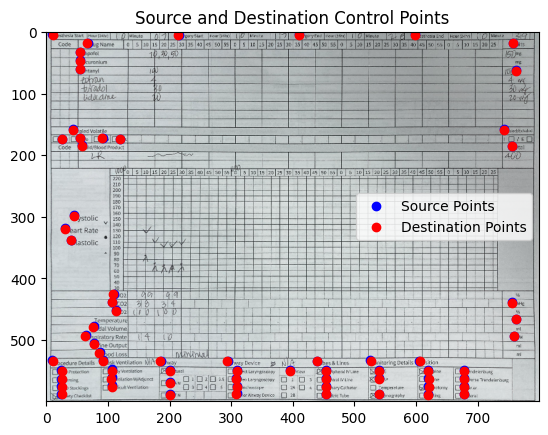

<class 'numpy.ndarray'>


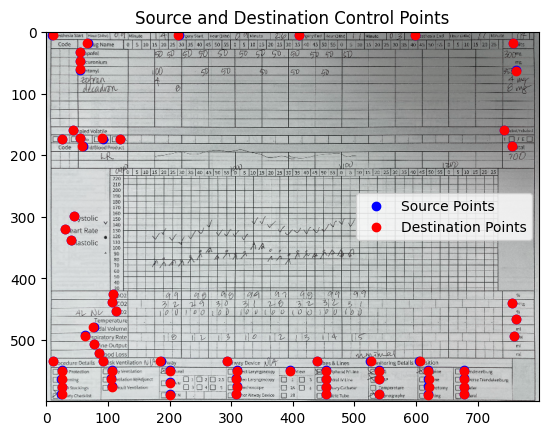

<class 'numpy.ndarray'>


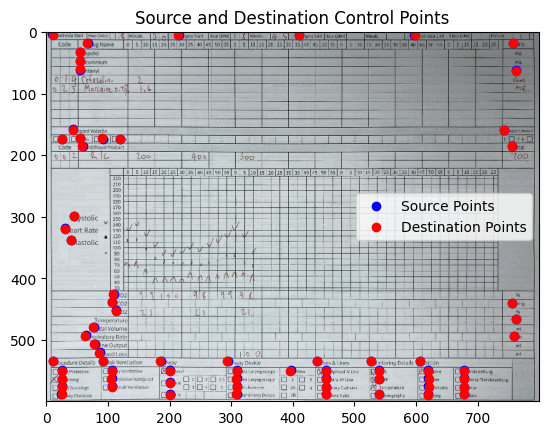

<class 'numpy.ndarray'>


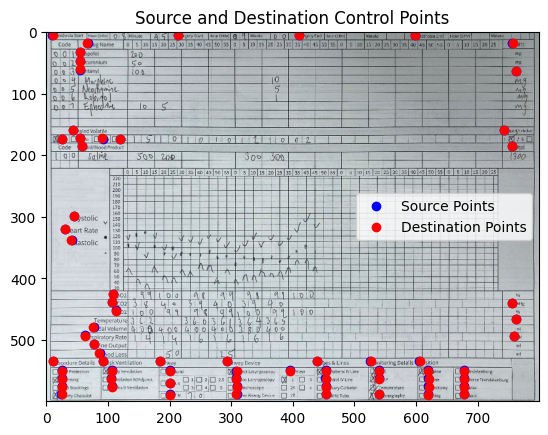

<class 'numpy.ndarray'>


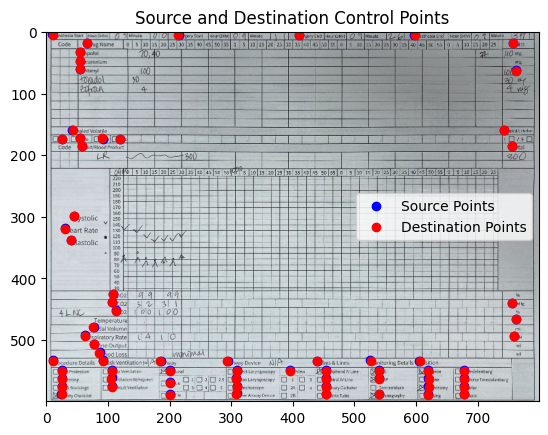

<class 'numpy.ndarray'>


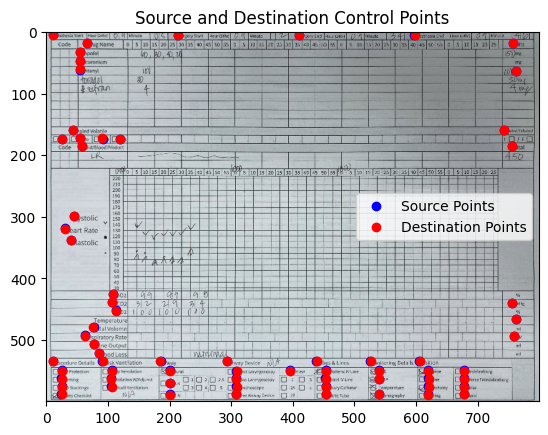

<class 'numpy.ndarray'>


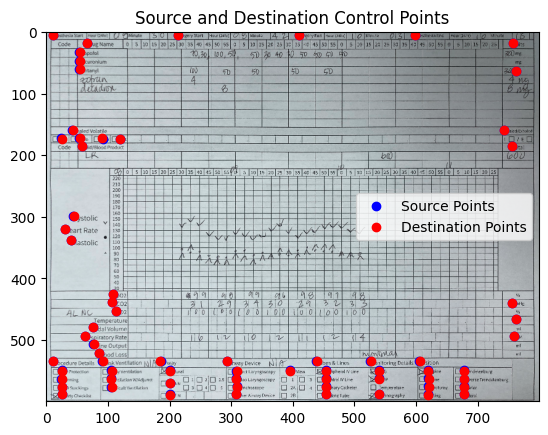

<class 'numpy.ndarray'>


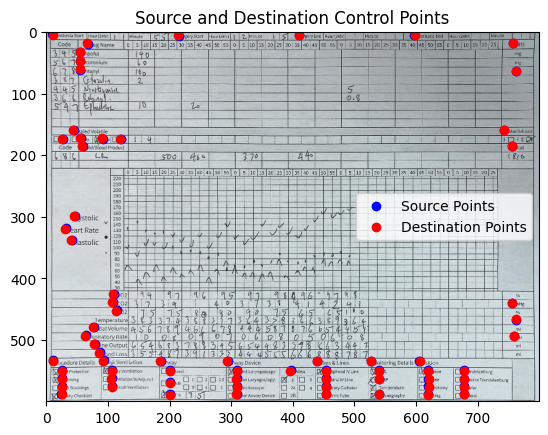

<class 'numpy.ndarray'>


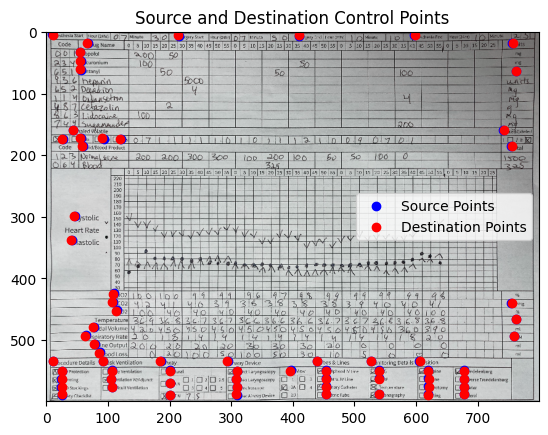

<class 'numpy.ndarray'>


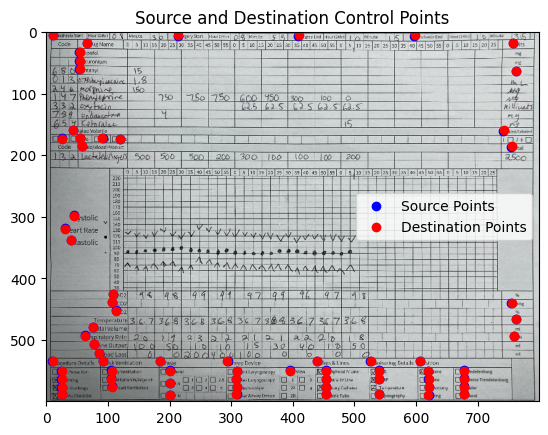

<class 'numpy.ndarray'>


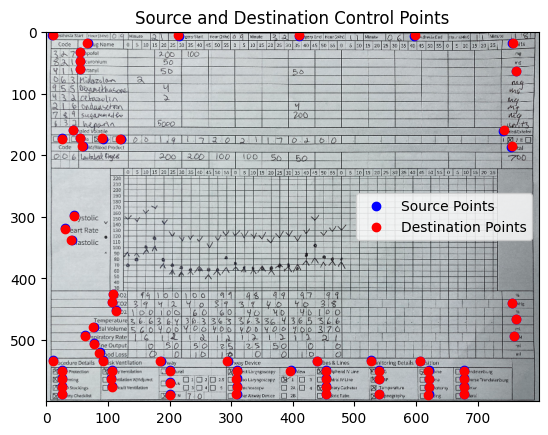

<class 'numpy.ndarray'>


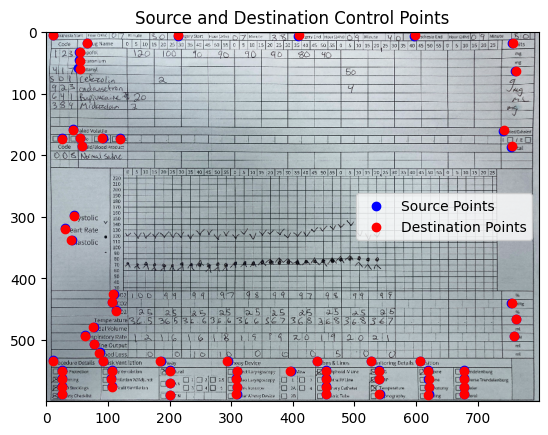

<class 'numpy.ndarray'>


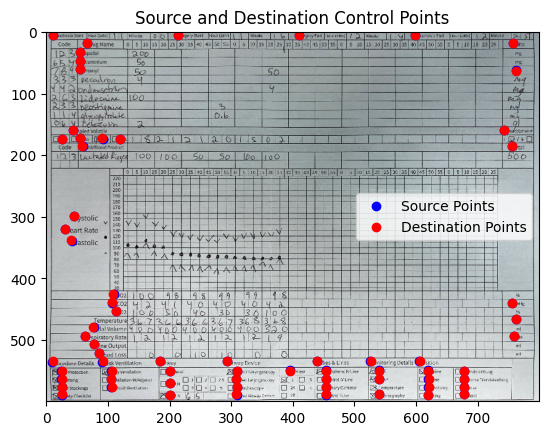

<class 'numpy.ndarray'>


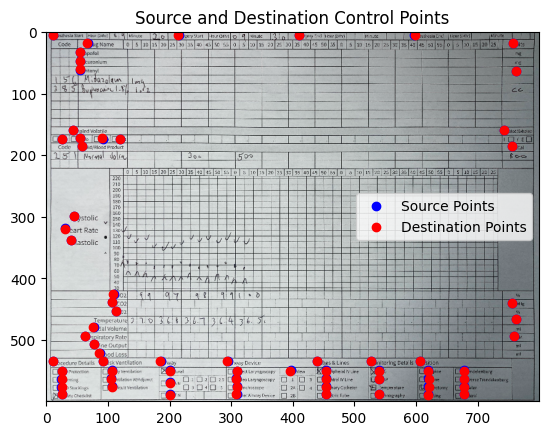

<class 'numpy.ndarray'>


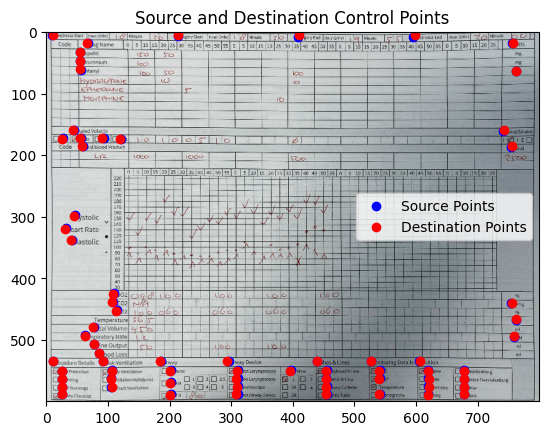

<class 'numpy.ndarray'>


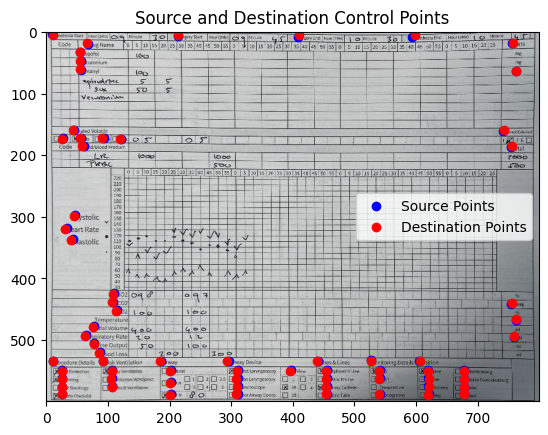

<class 'numpy.ndarray'>


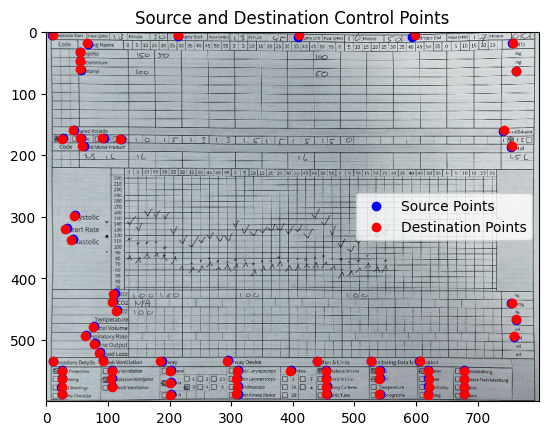

<class 'numpy.ndarray'>


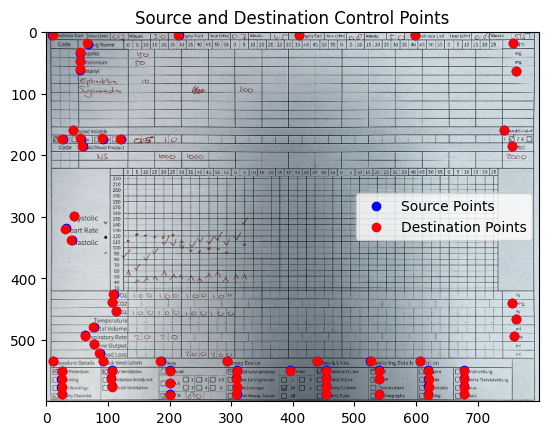

<class 'numpy.ndarray'>


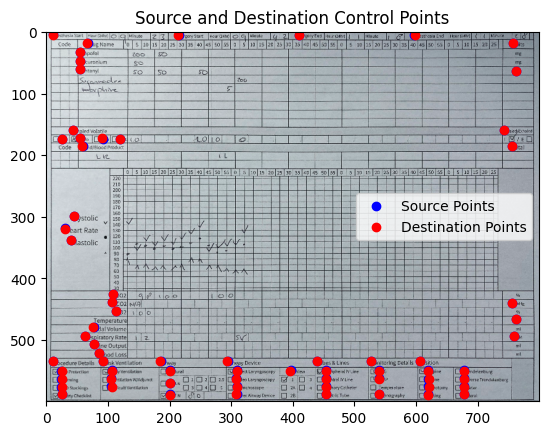

<class 'numpy.ndarray'>


In [ ]:
for sheet, yolo_bbs in yolo_data.items():
    # get path to current image
    full_image_path = os.path.join(PATH_TO_REGISTERED_IMAGES, sheet)
    image = cv2.imread(full_image_path)
    resized_img = cv2.resize(image, (DESIRED_IMAGE_WIDTH, DESIRED_IMAGE_HEIGHT))
    # get the sheet's bounding boxes
    sheet_bbs = [
        BoundingBox.from_yolo(bb, DESIRED_IMAGE_WIDTH, DESIRED_IMAGE_HEIGHT)
        for bb in yolo_bbs
    ]
    transformed_img = tps_transform(resized_img, sheet_bbs, landmarks)
    transformed_img = Image.fromarray(transformed_img)
    transformed_img.show()


In [ ]:
def tps_transform_ransac(image, src_bbs: List[BoundingBox], dst_bbs: List[BoundingBox]):
    """
    Perform a thin plate spline transformation on the image using the src_bbs and dst_bbs, using RANSAC to filter out outliers.

    Args:
        image (np.ndarray): The image to be transformed
        src_bbs (List[BoundingBox]): List of BoundingBox objects
        dst_bbs (List[BoundingBox]): List of BoundingBox objects

    Returns:
        np.ndarray: The transformed image
    """
    # get the categories from dst_bbs
    landmark_cats = [bb.category for bb in dst_bbs]
    # remove all bbs in src that are not in those categories
    src_bbs = [bb for bb in src_bbs if bb.category in landmark_cats]
    # get list of duplicate keys
    duplicate_count_src = dict(Counter([bb.category for bb in src_bbs]))
    duplicates = [k for k, v in duplicate_count_src.items() if v > 1]
    duplicate_count_dst = dict(Counter([bb.category for bb in dst_bbs]))
    duplicates.extend([k for k, v in duplicate_count_dst.items() if v > 1])
    duplicates = list(set(duplicates))
    # print(duplicates)
    # remove duplicates
    src_bbs = [bb for bb in src_bbs if bb.category not in duplicates]
    dst_bbs = [bb for bb in dst_bbs if bb.category not in duplicates]
    # sort categories alphabetically
    src_bbs = sorted(src_bbs, key=lambda bb: bb.category)
    # print([bb.category for bb in src_bbs])
    dst_bbs = sorted(dst_bbs, key=lambda bb: bb.category)
    # print([bb.category for bb in dst_bbs])

    src_bbs = np.array([[bb.left, bb.top] for bb in src_bbs], dtype=np.float32)
    dst_bbs = np.array([[bb.left, bb.top] for bb in dst_bbs], dtype=np.float32)

    _, mask = cv2.findHomography(
        dst_bbs,
        src_bbs,
        method=cv2.RANSAC,
        ransacReprojThreshold=10.0,
        maxIters=5000,
        confidence=0.99,
    )
    inlier_mask = mask.ravel() == 1

    filtered_src = src_bbs[inlier_mask]
    filtered_dst = dst_bbs[inlier_mask]

    new_src_x, new_src_y = filtered_src[:, 0], filtered_src[:, 1]
    new_dst_x, new_dst_y = filtered_dst[:, 0], filtered_dst[:, 1]

    if len(new_src_x) < 4:
        return image

    # use RBF function to do the thin plate splines
    rbf_x = Rbf(new_dst_x, new_dst_y, new_src_x, function="thin_plate")
    rbf_y = Rbf(new_dst_x, new_dst_y, new_src_y, function="thin_plate")

    # Alter the image according to the transformation
    h, w, _ = image.shape
    # create grid
    x = np.linspace(0, w - 1, w)
    y = np.linspace(0, h - 1, h)
    grid_x, grid_y = np.meshgrid(x, y)

    # apply the transformation
    # reshape into grid
    transformed_x = rbf_x(grid_x, grid_y).astype(np.float32)
    transformed_y = rbf_y(grid_x, grid_y).astype(np.float32)

    transformed_x = np.clip(transformed_x, 0, image.shape[1] - 1)
    transformed_y = np.clip(transformed_y, 0, image.shape[0] - 1)

    # warp the image
    warp_img = cv2.remap(
        image, transformed_x, transformed_y, interpolation=cv2.INTER_LINEAR
    )

    return warp_img

In [ ]:
for sheet, yolo_bbs in yolo_data.items():
    # get path to current image
    full_image_path = os.path.join(PATH_TO_REGISTERED_IMAGES, sheet)
    image = cv2.imread(full_image_path)
    resized_img = cv2.resize(image, (DESIRED_IMAGE_WIDTH, DESIRED_IMAGE_HEIGHT))
    # get the sheet's bounding boxes
    sheet_bbs = [
        BoundingBox.from_yolo(bb, DESIRED_IMAGE_WIDTH, DESIRED_IMAGE_HEIGHT)
        for bb in yolo_bbs
    ]
    transformed_img = tps_transform_ransac(resized_img, sheet_bbs, landmarks)
    transformed_img = Image.fromarray(transformed_img)
    transformed_img.show()


### Merging these two methods and priming for placing into extractor

I'm going to create private functions that do RANSAC and distance measurments


In [28]:
# Start with turning Hannah's code into a function
def __filter_by_distance(
    src_bbs: List[BoundingBox],
    dst_bbs: List[BoundingBox],
    threshold: float,
) -> Tuple[List[BoundingBox], List[BoundingBox]]:
    """
    Filter out source and destination points that have a distance greater than the threshold.
    Large transformations are likely to be outliers and erroneous. We only expect small tweaks via the thin plate spline transformation.
    Homography should already be completed prior to TPS.

    Args:
        src_bbs (List[BoundingBox]): The source points
        dst_bbs (List[BoundingBox]): The destination points
        threshold (float): The threshold distance

    Returns:
        Tuple[List[BoundingBox], List[BoundingBox]]: The filtered source and destination points

    """
    filtered_points = [
        (src_bb, dst_bb)
        for src_bb, dst_bb in zip(src_bbs, dst_bbs)
        if abs(src_bb.top - dst_bb.top) < threshold
        and abs(src_bb.left - dst_bb.left) < threshold
    ]

    new_src_bbs, new_dst_bbs = zip(*filtered_points) if filtered_points else ([], [])

    return list(new_src_bbs), list(new_dst_bbs)


# Now we can turn Matt's RANSAC code into a function
def __filter_by_RANSAC(
    src_bbs: List[BoundingBox],
    dst_bbs: List[BoundingBox],
    threshold: float,
    max_iters: int = 5000,
    confidence_limit: float = 0.99,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Filter out source and destination points that are not inliers according to RANSAC

    Args:
        src_bbs (np.ndarray): The source points
        dst_bbs (np.ndarray): The destination points
        threshold (float): The threshold distance
        max_iters (int, optional): The maximum number of iterations for RANSAC. Defaults to 5000.
        confidence_limit (float, optional): The confidence limit for RANSAC. Defaults to 0.99.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: The filtered source and destination points as numpy arrays in this order (src_x, src_y, dst_x, dst_y)
    """
    # Turn the BoundingBox objects into numpy arrays of coordinates
    src_points = np.array([[bb.left, bb.top] for bb in src_bbs], dtype=np.float32)
    dst_points = np.array([[bb.left, bb.top] for bb in dst_bbs], dtype=np.float32)

    # Complete RANSAC
    _, mask = cv2.findHomography(
        dst_points,
        src_points,
        method=cv2.RANSAC,
        ransacReprojThreshold=threshold,
        maxIters=max_iters,
        confidence=confidence_limit,
    )
    inlier_mask = mask.ravel() == 1

    # Apply the mask to the source and destination points
    filtered_src = src_points[inlier_mask]
    filtered_dst = dst_points[inlier_mask]

    # Get the x and y coordinates of the filtered points
    src_x, src_y = filtered_src[:, 0], filtered_src[:, 1]
    dst_x, dst_y = filtered_dst[:, 0], filtered_dst[:, 1]

    return src_x, src_y, dst_x, dst_y

In [30]:
# Now we need to merge the two functions into one that uses RANSAC to filter out outliers as well as those far from the destination points
def transform_thin_plate_splines(
    image: np.ndarray,
    src_bbs: List[BoundingBox],
    dst_bbs: List[BoundingBox],
    max_dist: float = 4.0,
    threshold: float = 10.0,
    max_iters: int = 5000,
    confidence_limit: float = 0.99,
) -> np.ndarray:
    """
    Perform a thin plate spline transformation on the image using the src_bbs and dst_bbs, using RANSAC to filter out outliers.
    We assume that homography was completed prior to calling this function.
    We start by filtering by points that are too far from their destination counterparts, then we use RANSAC to filter out outliers.

    Args:
        image (np.ndarray): The image to be transformed
        src_bbs (List[BoundingBox]): List of BoundingBox objects
        dst_bbs (List[BoundingBox]): List of BoundingBox objects
        max_dist (float, optional): The maximum distance for filtering out points. Defaults to 4.0.
        threshold (float, optional): The threshold distance for RANSAC. Defaults to 10.0.
        max_iters (int, optional): The maximum number of iterations for RANSAC. Defaults to 5000.
        confidence_limit (float, optional): The confidence limit for RANSAC. Defaults to 0.99.

    Returns:
        np.ndarray: The transformed image
    """
    # get the categories from dst_bbs
    landmark_cats = [bb.category for bb in dst_bbs]
    # remove all bbs in src that are not in those categories
    src_bbs = [bb for bb in src_bbs if bb.category in landmark_cats]
    # get list of duplicate keys
    duplicate_count_src = dict(Counter([bb.category for bb in src_bbs]))
    duplicates = [k for k, v in duplicate_count_src.items() if v > 1]
    duplicate_count_dst = dict(Counter([bb.category for bb in dst_bbs]))
    duplicates.extend([k for k, v in duplicate_count_dst.items() if v > 1])
    duplicates = list(set(duplicates))
    # print(duplicates)
    # remove duplicates
    src_bbs = [bb for bb in src_bbs if bb.category not in duplicates]
    dst_bbs = [bb for bb in dst_bbs if bb.category not in duplicates]

    # sort categories alphabetically
    src_bbs = sorted(src_bbs, key=lambda bb: bb.category)
    dst_bbs = sorted(dst_bbs, key=lambda bb: bb.category)

    # remove source points with suspiciously high distances to their destination counterparts
    src_bbs, dst_bbs = __filter_by_distance(src_bbs, dst_bbs, max_dist)

    # Now lets use RAANSAC to filter out outliers
    src_x, src_y, dst_x, dst_y = __filter_by_RANSAC(
        src_bbs, dst_bbs, threshold, max_iters, confidence_limit
    )

    # use RBF function to do the thin plate splines
    rbf_x = Rbf(dst_x, dst_y, src_x, function="thin_plate")
    rbf_y = Rbf(dst_x, dst_y, src_y, function="thin_plate")

    # Alter the image according to the transformation
    h, w, _ = image.shape
    # create grid
    x = np.linspace(0, w - 1, w)
    y = np.linspace(0, h - 1, h)
    grid_x, grid_y = np.meshgrid(x, y)

    # apply the transformation
    # reshape into grid
    transformed_x = rbf_x(grid_x, grid_y).astype(np.float32)
    transformed_y = rbf_y(grid_x, grid_y).astype(np.float32)

    transformed_x = np.clip(transformed_x, 0, image.shape[1] - 1)
    transformed_y = np.clip(transformed_y, 0, image.shape[0] - 1)

    # warp the image
    warp_img = cv2.remap(
        image, transformed_x, transformed_y, interpolation=cv2.INTER_LINEAR
    )

    return warp_img


In [31]:
for sheet, yolo_bbs in yolo_data.items():
    # get path to current image
    full_image_path = os.path.join(PATH_TO_REGISTERED_IMAGES, sheet)
    image = cv2.imread(full_image_path)
    resized_img = cv2.resize(image, (DESIRED_IMAGE_WIDTH, DESIRED_IMAGE_HEIGHT))
    # get the sheet's bounding boxes
    sheet_bbs = [
        BoundingBox.from_yolo(bb, DESIRED_IMAGE_WIDTH, DESIRED_IMAGE_HEIGHT)
        for bb in yolo_bbs
    ]
    transformed_img = transform_thin_plate_splines(resized_img, sheet_bbs, landmarks)
    transformed_img = Image.fromarray(transformed_img)
    transformed_img.show()